<a href="https://colab.research.google.com/github/E-Fung/Classification_PCD/blob/main/Copy_of_PCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INITIALIZE LIBRARIES AND FINAL FILE NAMES**

In [154]:
#########################################################################################################################################################################
#   Initialize libraries and such
#########################################################################################################################################################################

%tensorflow_version 2.x  # this line is not required unless you are in a notebook
from __future__ import absolute_import, division, print_function, unicode_literals
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import math

# Print versions
!python --versions
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

tflite_model_name = 'PCD_Model'
c_model_name = 'PCD_Model'

class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

#########################################################################################################################################################################

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
unknown option --versions
usage: python3 [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.
Numpy 1.19.5
TensorFlow 2.4.1
Keras 2.4.0


# **UPLOADING**

In [47]:
#########################################################################################################################################################################
#   Uploading Files
#########################################################################################################################################################################

file_name = 'data_n02' #Change this to the name of the csv file you are uploading
uploaded = files.upload()
pd.read_csv(io.StringIO(uploaded[file_name+'.csv'].decode('utf-8')))

#########################################################################################################################################################################

Saving data_n02.csv to data_n02.csv


,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,Class
0,-90.87,-5.17,-23.28,-40.72,12.47,27.22,-130.25,-25.88,7.67,-145.70,-28.46,11.40,0
1,-90.87,-5.19,-23.37,-40.40,12.78,27.48,-130.12,-26.02,8.02,-145.76,-28.53,12.14,0
2,-90.69,-5.35,-23.56,-39.92,13.16,28.07,-129.98,-25.98,9.23,-145.84,-28.58,12.73,0
3,-90.21,-5.73,-23.95,-39.66,13.21,28.37,-129.94,-26.12,9.52,-145.93,-28.61,13.35,0
4,-89.83,-5.94,-24.10,-39.51,13.24,28.34,-130.00,-26.45,9.46,-146.10,-28.62,14.22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14301,-28.72,-1.36,-33.53,-171.01,-9.08,39.72,81.73,-34.58,-11.76,-87.74,-33.85,-22.84,4
14302,-29.25,-1.57,-33.74,-171.09,-9.39,39.97,81.31,-34.50,-11.66,-88.20,-33.78,-22.83,4
14303,-29.66,-1.64,-33.74,-171.12,-9.61,40.10,80.92,-34.52,-11.65,-88.53,-33.79,-22.80,4
14304,-30.08,-1.65,-33.75,-171.08,-9.83,40.26,80.32,-34.68,-11.77,-88.88,-33.80,-22.73,4


# **PROCESSING**

In [55]:
test_data = 'data_n03'
train_data_01 = 'data_n02'
train_data_02 = 'data_n01'
train_data_03 = 'data_n04'
train_data_04 = 'data_n05'
train_data1 = pd.read_csv(train_data_01+'.csv')
train_data2 = pd.read_csv(train_data_02+'.csv')
train_data3 = pd.read_csv(train_data_03+'.csv')
train_data4 = pd.read_csv(train_data_04+'.csv')
test = pd.read_csv(test_data+'.csv')
test

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,Class
0,75.50,-17.09,-26.18,-137.50,20.70,24.71,-102.47,-22.92,22.90,-172.53,-25.80,23.06,0
1,76.02,-17.42,-26.28,-137.28,20.98,24.78,-102.01,-23.05,22.95,-172.37,-25.89,23.10,0
2,76.53,-17.75,-26.45,-137.06,21.11,24.98,-101.43,-23.30,22.72,-172.38,-25.77,23.17,0
3,77.46,-18.21,-26.74,-136.44,21.68,25.09,-100.81,-23.61,22.21,-172.36,-25.75,23.37,0
4,78.07,-18.48,-26.92,-136.03,22.14,25.17,-100.62,-23.61,22.50,-172.19,-25.83,24.05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12878,45.56,-4.08,-33.29,78.48,-8.05,37.11,-151.62,-34.77,-4.18,146.96,-29.73,-23.18,4
12879,45.13,-3.99,-33.46,78.33,-8.10,37.16,-152.17,-34.91,-4.08,146.94,-29.72,-23.34,4
12880,44.56,-3.85,-33.49,78.12,-8.14,37.21,-152.67,-35.13,-4.10,146.87,-29.75,-23.43,4
12881,44.18,-3.74,-33.38,77.92,-8.11,37.22,-153.18,-35.36,-4.20,146.77,-29.90,-23.58,4


Text(0.5, 0, 'postures')

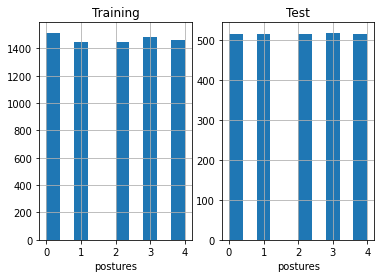

In [149]:
#########################################################################################################################################################################
#   This block of code is for processing the data
#########################################################################################################################################################################

#Change these
train_row_increments = 5
test_row_increments = 5
test_data = 'data_n03'
train_data_01 = 'data_n05'
train_data_02 = 'data_n02'
train_data_03 = 'data_n01'
train_data_04 = 'data_n04'

#Initialize dataframes for storing the data and combine them to increase effectiveness of model
train_data1 = pd.read_csv(train_data_01+'.csv')
train_data2 = pd.read_csv(train_data_02+'.csv')
train_data3 = pd.read_csv(train_data_03+'.csv')
train_data4 = pd.read_csv(train_data_04+'.csv')
train_data_combined = pd.concat([train_data1,train_data2,train_data3,train_data4],ignore_index=True)

#Process the data::
train_data_sampled = train_data_combined[1::train_row_increments]
# train_data_sampled = train_data_combined[1::train_row_increments]#sample every 'train_row_increments' row (IMUs give data very frequently so the data is very similar)
data_shuffled = train_data_sampled.sample(frac=1).reset_index(drop=True)#shuffle it
d0 = data_shuffled.loc[data_shuffled['Class'] == 0]#how much data for each posture
d1 = data_shuffled.loc[data_shuffled['Class'] == 1]
d2 = data_shuffled.loc[data_shuffled['Class'] == 2]
d3 = data_shuffled.loc[data_shuffled['Class'] == 3]
d4 = data_shuffled.loc[data_shuffled['Class'] == 4]
min_class = min(len(d0),len(d1),len(d2),len(d3),len(d4))
d0_split = d0.sample(frac=(min_class/len(d0)),random_state=1) #get the same amount for each posture
d1_split = d1.sample(frac=(min_class/len(d1)),random_state=1) 
d2_split = d2.sample(frac=(min_class/len(d2)),random_state=1) 
d3_split = d3.sample(frac=(min_class/len(d3)),random_state=1) 
d4_split = d4.sample(frac=(min_class/len(d4)),random_state=1) 
data_final_combine = pd.concat([d0_split,d1_split,d2_split,d3_split,d4_split],ignore_index=True)#combine
data_processed = data_final_combine.sample(frac=1).reset_index(drop=True)#shuffle again
posture_processed = data_processed.pop('Class')
data_processed = data_processed/180

#Split the data into 3 sets:: Training, Validation(used to check against overfitting, you dont want training accuracy to be over validation) 
val_ratio = 0.3    # Percentage of samples that should be held for validation set
length_data_processed = data_processed.shape[0]
val_split = int(val_ratio * length_data_processed)
x_val, x_train = np.split(data_processed, [val_split])
y_val, y_train = np.split(posture_processed, [val_split])
assert(x_train.size + x_val.size) == data_processed.size
plt.subplot(1,2,1)
y_train.hist() #displays the histogram based on posture
plt.title("Training")
plt.xlabel('postures')

#Process the data for the testing data (This will be data from a new user that has never had their data in the training set)
test = pd.read_csv(test_data+'.csv')
test = test [1::test_row_increments]
test = test.sample(frac=1).reset_index(drop=True)
test_pop = test.pop('Class')
test = test / 180
plt.subplot(1,2,2)
test_pop.hist()
plt.title("Test")
plt.xlabel('postures')

#########################################################################################################################################################################

# **TRAINING**

Model: "sequential_850"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_850 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 65)                845       
_________________________________________________________________
dropout_1700 (Dropout)       (None, 65)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 25)                1650      
_________________________________________________________________
dropout_1701 (Dropout)       (None, 25)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 130       
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
__________________________________________________

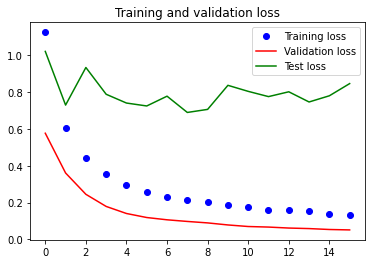

81/81 - 0s - loss: 0.8462 - accuracy: 0.7043

Test accuracy: 0.7043073177337646


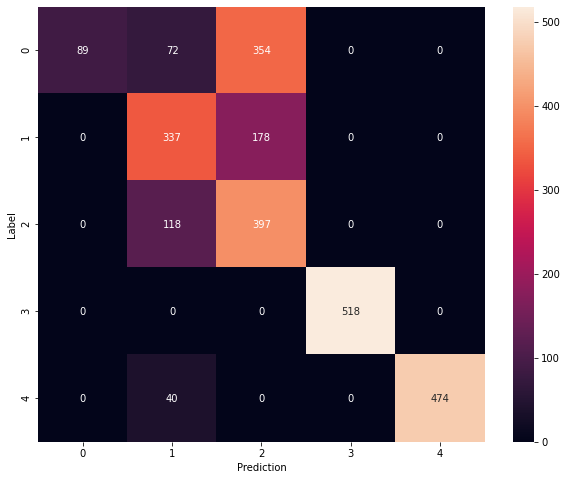

Model: "sequential_851"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_851 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 65)                845       
_________________________________________________________________
dropout_1702 (Dropout)       (None, 65)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 25)                1650      
_________________________________________________________________
dropout_1703 (Dropout)       (None, 25)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 130       
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
__________________________________________________

KeyboardInterrupt: ignored

In [189]:
#########################################################################################################################################################################
#   This block of code is for trying different model configurations and seeing what works best
#########################################################################################################################################################################

#Affects the range of layers that the models will have and how much times we want to test that setup
i_range = 1
j_range = 1
k_range = 4

hidden_layer_1 = 65
hidden_layer_2 = 25
hidden_layer_1_interval = 5
hidden_layer_2_interval = 5

starting_num_epochs = 60

dropout_percent = 0.2

callback_delta=0.01
callback_patience=2
#########################################################################################################################################################################

curr_run = 0
total_run = i_range*j_range*k_range 

#Test different configuration of models
test_history = pd.DataFrame(columns=['Accuracy','Layer 1','Layer 2','Dropout %','Average of'])
for i in range(0,i_range):
  for j in range(0,j_range):
    average_accuracy = 0;
    for k in range(0,k_range):
      curr_run = curr_run + 1
      initial_learning_rate = (hidden_layer_1+i*hidden_layer_1_interval)/10000
      #Creates the model structure and chooses the activation function for each layer
      model = tf.keras.Sequential([                      
          tf.keras.layers.Flatten(input_shape=(12,1)),
          tf.keras.layers.Dense(hidden_layer_1+i*hidden_layer_1_interval, activation='relu', name= "Layer_1"),  #hidden layers are generally: relu, sigmoid, tanh (Usually constant for all hidden layers)
          tf.keras.layers.Dropout(dropout_percent), #dropouts only occur during training
          tf.keras.layers.Dense(hidden_layer_2+j*hidden_layer_2_interval, activation='relu', name= "Layer_2"),  
          tf.keras.layers.Dropout(dropout_percent),
          tf.keras.layers.Dense(5, activation='linear', name= "Predicted_Posture"), #output layers are generally: linear, sigmoid, softmax
      ])
      model.summary()

      

      #Stops the model training early to prevent overfitting
      callbacks = [
      tf.keras.callbacks.EarlyStopping(# Stop training when `val_loss` is no longer improving
          monitor="val_accuracy",
          # min_delta=callback_delta,
          mode='auto',
          patience=callback_patience,# "no longer improving" being further defined as "for at least x epochs"
          verbose=1,
        )
      ] 

      val_test = AdditionalValidationSets([(test, test_pop, 'val2')])

      #Assign type of: optimizer, loss, and metric
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=200, decay_rate=0.90, staircase=True)
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
      model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

      # model.compile(optimizer=opt,loss=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.CategoricalCrossentropy()],metrics=[tf.keras.metrics.CategoricalAccuracy(),], )

      #Print out which loop we are undergoing
      print(curr_run)
      print("out of ")
      print(total_run)

      #Train the model with the training data and save the stats in history
      history = model.fit(x_train,y_train,epochs=starting_num_epochs,callbacks = [val_test,callbacks],validation_data=(x_val, y_val))

      #Plots the training vs validation loss
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      test_loss = val_test.history['val2_loss']
      epochs = history.epoch
      plt.plot(epochs, loss, 'bo', label='Training loss')
      plt.plot(epochs, val_loss, 'r', label='Validation loss')
      plt.plot(epochs, test_loss, 'g', label='Test loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.show()

      #Test the model with unseen data from the original training dataset that was split
      # x_test_loss, x_test_acc = model.evaluate(x_test,  y_test, verbose=2)
      # print('\nX_Test accuracy:', x_test_acc)

      #Test the model with unseen data and record the settings
      test_loss, test_acc = model.evaluate(test,  test_pop, verbose=2)
      print('\nTest accuracy:', test_acc)

      #create a confusion matrix to see model performance
      predictions = model.predict(test)
      predictions = np.argmax(predictions,axis = 1)
      confusion_mtx = tf.math.confusion_matrix(
          test_pop, predictions, 5, weights=None, dtype=tf.dtypes.int32,
          name='PCD_Confusion_Matrix'
      )
      plt.figure(figsize=(10, 8))
      sns.heatmap(confusion_mtx,annot=True, fmt='g')
      plt.xlabel('Prediction')
      plt.ylabel('Label')
      plt.show()
      average_accuracy = average_accuracy + test_acc

    #Records the test results for specific model configuration
    average_accuracy = average_accuracy/k_range
    new_row = {'Accuracy':average_accuracy,'Layer 1':hidden_layer_1+i*hidden_layer_1_interval,'Layer 2':hidden_layer_2+j*hidden_layer_2_interval,'Dropout %':dropout_percent,'Average of':k_range}
    test_history = test_history.append(new_row, ignore_index=True)
test_history.to_csv('Dropout_01_6.csv',index=False)
from google.colab import files
files.download("Dropout_01_6.csv")
#########################################################################################################################################################################

In [ ]:
#val_test.history

In [73]:
 test_history

,Accuracy,Layer 1,Layer 2,Dropout %,Average of
0,0.621548,60.0,30.0,0.0,4.0
1,0.688059,60.0,35.0,0.0,4.0
2,0.655679,60.0,40.0,0.0,4.0
3,0.641190,60.0,45.0,0.0,4.0
4,0.631855,60.0,50.0,0.0,4.0


In [ ]:
predictions = model.predict(test)
predictions = np.argmax(predictions)
predictions


In [76]:
from google.colab import files
test_history.to_csv('Dropout_01_5.csv',index=False)
files.download("Dropout_01_5.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **CONVERT**

In [99]:
#########################################################################################################################################################################
#   Optimize the model for size and convert to tflite model
#########################################################################################################################################################################

#Covert the model to a tflite model & optimize to reduce the size
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

#########################################################################################################################################################################

INFO:tensorflow:Assets written to: /tmp/tmp7zmu5mu3/assets


7792

In [100]:
#########################################################################################################################################################################
#   Function to convert tflite file to C header file
#########################################################################################################################################################################

# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

#########################################################################################################################################################################

In [101]:
#########################################################################################################################################################################
#   Convert to c-header file via function
#########################################################################################################################################################################

# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))

#########################################################################################################################################################################